## All-by-all correlation

1. $\sum F^T_Y$ $\hspace{1cm}$(Top particle)
2. $\sum F^T_X$ $\hspace{1cm}$(Top particle)
3. $\sum F^C_Y$ $\hspace{1cm}$(Center particle)
4. $\sum F^C_X$ $\hspace{1cm}$(Center particle)
5. $\sum F^B_Y$ $\hspace{1cm}$(Bottom particle)
6. $\sum F^B_X$ $\hspace{1cm}$(Bottom particle)
7. $F^{CT}_N$ $\hspace{1cm}$(Center particle, top contact)
8. $F^{CT}_T$ $\hspace{1cm}$(Center particle, top contact)
9. $F^{CB}_N$ $\hspace{1cm}$(Center particle, bottom contact)
10. $F^{CB}_T$ $\hspace{1cm}$(Center particle, bottom contact)
11. $F^{TB}_N$ $\hspace{1cm}$(Top particle, bottom contact)
12. $F^{TB}_T$ $\hspace{1cm}$(Top particle, bottom contact)
13. $F^{BT}_N$ $\hspace{1cm}$(Bottom particle, top contact)
14. $F^{BT}_T$ $\hspace{1cm}$(Bottom particle, top contact)
15. $\mu^{CT} = F_T / F_N$ $\hspace{1cm}$(Center particle, top contact)
16. $\mu^{CB}$ $\hspace{1cm}$(Center particle, bottom contact)
17. $\mu^{TB}$ $\hspace{1cm}$(Top particle, bottom contact)
18. $\mu^{BT}$ $\hspace{1cm}$(Bottom particle, top contact)
19. $v^T$ $\hspace{1cm}$(Top particle)
20. $v^C$ $\hspace{1cm}$(Center particle)
21. $v^B$ $\hspace{1cm}$(Bottom particle)
22. $\dot \theta^T$ $\hspace{1cm}$(Top particle)
23. $\dot \theta^C$ $\hspace{1cm}$(Center particle)
24. $\dot \theta^B$ $\hspace{1cm}$(Bottom particle)
25. $R^T = \dot \theta r / v$ $\hspace{1cm}$(Top particle)
26. $R^C$ $\hspace{1cm}$(Center particle)
27. $R^B$ $\hspace{1cm}$(Bottom particle)
28. $s$ $\hspace{1cm}$(Top to bottom separation)

In [39]:
def calcAllParams(trial, velocitySmoothingKernel=101):
    # Calculate the parameters for all timesteps (though we may only take one later)
    params = {}
    
    topParticle = trial.particleNear([200, 600])
    centerParticle = trial.particleNear([500, 500])
    bottomParticle = trial.particleNear([800, 600])
    
    # Force Balance
    
    topForceBalance = testForceBalance(trial.forceArr[topParticle], trial.alphaArr[topParticle], trial.betaArr[topParticle])
    centerForceBalance = testForceBalance(trial.forceArr[centerParticle], trial.alphaArr[centerParticle], trial.betaArr[centerParticle])
    bottomForceBalance = testForceBalance(trial.forceArr[bottomParticle], trial.alphaArr[bottomParticle], trial.betaArr[bottomParticle])
        
    params["\\sum F^T_Y"] = topForceBalance[:,0] # 1
    params["\\sum F^T_X"] = topForceBalance[:,1] # 2
    params["\\sum F^C_Y"] = centerForceBalance[:,0] # 3
    params["\\sum F^C_X"] = centerForceBalance[:,1] # 4
    params["\\sum F^B_Y"] = bottomForceBalance[:,0] # 5
    params["\\sum F^B_X"] = bottomForceBalance[:,1] # 6
    
    # Normal and Tangential
    
    centerParticleTopForce = np.argmin(np.abs(trial.averageForcePositions(centerParticle) - np.pi))
    centerParticleBottomForce = np.argmin(np.abs(trial.averageForcePositions(centerParticle)))

    topParticleBottomForce = np.argmin(np.abs(trial.averageForcePositions(centerParticle)))
    bottomParticleTopForce = np.argmin(np.abs(trial.averageForcePositions(centerParticle) - np.pi))
    
    params["F^{CT}_T"] = trial.forceArr[centerParticle][centerParticleTopForce] * np.sin(trial.alphaArr[centerParticle][centerParticleTopForce])
    params["F^{CT}_N"] = trial.forceArr[centerParticle][centerParticleTopForce] * np.cos(trial.alphaArr[centerParticle][centerParticleTopForce])
    params["F^{CB}_T"] = trial.forceArr[centerParticle][centerParticleBottomForce] * np.sin(trial.alphaArr[centerParticle][centerParticleBottomForce])
    params["F^{CB}_N"] = trial.forceArr[centerParticle][centerParticleBottomForce] * np.cos(trial.alphaArr[centerParticle][centerParticleBottomForce])
    
    params["F^{TB}_T"] = trial.forceArr[topParticle][topParticleBottomForce] * np.sin(trial.alphaArr[topParticle][topParticleBottomForce])
    params["F^{TB}_N"] = trial.forceArr[topParticle][topParticleBottomForce] * np.cos(trial.alphaArr[topParticle][topParticleBottomForce])
    params["F^{BT}_T"] = trial.forceArr[bottomParticle][bottomParticleTopForce] * np.sin(trial.alphaArr[bottomParticle][bottomParticleTopForce])
    params["F^{BT}_N"] = trial.forceArr[bottomParticle][bottomParticleTopForce] * np.cos(trial.alphaArr[bottomParticle][bottomParticleTopForce])

    # Coefficients of Friction
    
    params["\\mu^{CT}"] = np.abs([params["F^{CT}_T"][i] / params["F^{CT}_N"][i] if params["F^{CT}_N"][i] != 0 else 0 for i in range(trial.numTimesteps)])
    params["\\mu^{CB}"] = np.abs([params["F^{CB}_T"][i] / params["F^{CB}_N"][i] if params["F^{CB}_N"][i] != 0 else 0 for i in range(trial.numTimesteps)])
    params["\\mu^{TB}"] = np.abs([params["F^{TB}_T"][i] / params["F^{TB}_N"][i] if params["F^{TB}_N"][i] != 0 else 0 for i in range(trial.numTimesteps)])
    params["\\mu^{BT}"] = np.abs([params["F^{BT}_T"][i] / params["F^{BT}_N"][i] if params["F^{BT}_N"][i] != 0 else 0 for i in range(trial.numTimesteps)])

    # Velocities

    smoothedTopVelocityY = derivative(savgol_filter(trial.centerArr[topParticle][:,0], velocitySmoothingKernel, 1))
    smoothedTopVelocityX = derivative(savgol_filter(trial.centerArr[topParticle][:,1], velocitySmoothingKernel, 1))
    
    smoothedCenterVelocityY = derivative(savgol_filter(trial.centerArr[centerParticle][:,0], velocitySmoothingKernel, 1))
    smoothedCenterVelocityX = derivative(savgol_filter(trial.centerArr[centerParticle][:,1], velocitySmoothingKernel, 1))

    smoothedBottomVelocityY = derivative(savgol_filter(trial.centerArr[bottomParticle][:,0], velocitySmoothingKernel, 1))
    smoothedBottomVelocityX = derivative(savgol_filter(trial.centerArr[bottomParticle][:,1], velocitySmoothingKernel, 1))
    
    params["v^T"] = np.sqrt(smoothedTopVelocityY**2 + smoothedTopVelocityX**2)
    params["v^C"] = np.sqrt(smoothedCenterVelocityY**2 + smoothedCenterVelocityX**2)
    params["v^B"] = np.sqrt(smoothedBottomVelocityY**2 + smoothedBottomVelocityX**2)

    # Angular Velocities
    
    smoothedTopAngularVelocity = derivative(savgol_filter(trial.angleArr[topParticle], velocitySmoothingKernel, 1))
    smoothedCenterAngularVelocity = derivative(savgol_filter(trial.angleArr[centerParticle], velocitySmoothingKernel, 1))
    smoothedBottomAngularVelocity = derivative(savgol_filter(trial.angleArr[bottomParticle], velocitySmoothingKernel, 1))

    params["\\omega^T"] = np.abs(smoothedTopAngularVelocity)
    params["\\omega^C"] = np.abs(smoothedCenterAngularVelocity)
    params["\\omega^B"] = np.abs(smoothedBottomAngularVelocity)

    # Rolling coefficients
    
    params["R^T"] = [params["v^T"][i] * trial.radiusArr[topParticle][i] / params["\\omega^T"][i] if params["\\omega^T"][i] != 0 else 0 for i in range(trial.numTimesteps)] 
    params["R^C"] = [params["v^C"][i] * trial.radiusArr[centerParticle][i] / params["\\omega^C"][i] if params["\\omega^C"][i] != 0 else 0 for i in range(trial.numTimesteps)] 
    params["R^B"] = [params["v^B"][i] * trial.radiusArr[bottomParticle][i] / params["\\omega^B"][i] if params["\\omega^B"][i] != 0 else 0 for i in range(trial.numTimesteps)] 

    # Separation
    
    separation = np.sqrt(np.sum((trial.centerArr[topParticle] - trial.centerArr[bottomParticle]).astype(np.float64)**2, axis=-1)) - trial.radiusArr[topParticle] - trial.radiusArr[bottomParticle]
    
    params["s"] = separation
    
    # Interpolate for all nan values, since that messes up
    # any linear regression
#     for k,v in params.items():
#         nanIndices = np.where(np.isnan(v))[0]
#         newValues = v.copy()
        
#         # We have to be careful of consecutive nan values
#         for i in range(len(nanIndices)):
#             previousGoodPoint = [ind for ind in np.arange(nanIndices[i]) if not ind in nanIndices]
#             previousGoodPoint = previousGoodPoint[-1] if len(previousGoodPoint) > 0 else 0
#             nextGoodPoint = [ind for ind in np.arange(nanIndices[i], len(v)) if not ind in nanIndices]
#             nextGoodPoint = nextGoodPoint[0] if len(nextGoodPoint) > 0 else -1
            
#             newValues[nanIndices[i]] = (v[previousGoodPoint] * (nanIndices[i] - previousGoodPoint) + v[nextGoodPoint] * (nextGoodPoint - nanIndices[i])) / (nextGoodPoint - previousGoodPoint)
            
#         params[k] = newValues
    
    return params

In [2]:
import numpy as np
import os 
import time

from scipy.signal import savgol_filter
from scipy.stats import linregress

# My custom library of photoelastic tools
import sys
sys.path.append('/eno/jdfeathe/pepe/')
#sys.path.append('/home/jack//workspaces/jupyter-workspace/pepe/')

from pepe.auto import Trial
from pepe.analysis import derivative, determineLinearRegions, testForceBalance
from pepe.visualize import genColors

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 140
plt.rcParams["font.size"] = 13
plt.rcParams["image.cmap"] = 'plasma'

In [4]:
syntheticFolder = '../'
#syntheticFolder = '/eno/jdfeathe/DATA/SpaceJam_Synthetic/'
dataKey = '2022-04-29_'
radius = 160

fileList = os.listdir(syntheticFolder)

fileList = np.sort([f for f in fileList if dataKey in f and not 'NoAir' in f])
#fileList = fileList[:3]

speedArr = [float(f.split('_')[1]) for f in fileList]
stiffnessArr = [f.split('_')[2] for f in fileList]

fileList

array(['2022-04-29_100_MHS_Gap1_0_Synthetic',
       '2022-04-29_100_MHS_Gap1_1_Synthetic',
       '2022-04-29_100_MHS_Gap1_2_Synthetic',
       '2022-04-29_100_MHS_Gap1_3_Synthetic',
       '2022-04-29_100_MHS_Gap1_4_Synthetic',
       '2022-04-29_100_MHS_Gap1_5_Synthetic',
       '2022-04-29_100_MHS_Gap2_0_Synthetic',
       '2022-04-29_100_MHS_Gap2_1_Synthetic',
       '2022-04-29_100_MHS_Gap2_2_Synthetic',
       '2022-04-29_100_MHS_Gap2_3_Synthetic',
       '2022-04-29_100_MHS_Gap2_4_Synthetic',
       '2022-04-29_100_MHS_Gap2_5_Synthetic',
       '2022-04-29_100_MHS_Gap3_0_Synthetic',
       '2022-04-29_100_MHS_Gap3_1_Synthetic',
       '2022-04-29_100_MHS_Gap3_2_Synthetic',
       '2022-04-29_100_MHS_Gap3_3_Synthetic',
       '2022-04-29_100_MHS_Gap3_4_Synthetic',
       '2022-04-29_100_MHS_Gap3_5_Synthetic'], dtype='<U35')

## Within Single Trial

In [45]:
trial = Trial(syntheticFolder + fileList[2])
trial.fixAllNan()

params = calcAllParams(trial)

paramKeys = list(params.keys())

for k,v in params.items():
    print(k, len(np.where(np.isnan(v))[0]))

\sum F^T_Y 0
\sum F^T_X 0
\sum F^C_Y 0
\sum F^C_X 0
\sum F^B_Y 0
\sum F^B_X 0
F^{CT}_T 0
F^{CT}_N 0
F^{CB}_T 0
F^{CB}_N 0
F^{TB}_T 0
F^{TB}_N 0
F^{BT}_T 0
F^{BT}_N 0
\mu^{CT} 0
\mu^{CB} 0
\mu^{TB} 0
\mu^{BT} 0
v^T 0
v^C 0
v^B 0
\omega^T 0
\omega^C 0
\omega^B 0
R^T 0
R^C 0
R^B 0
s 0


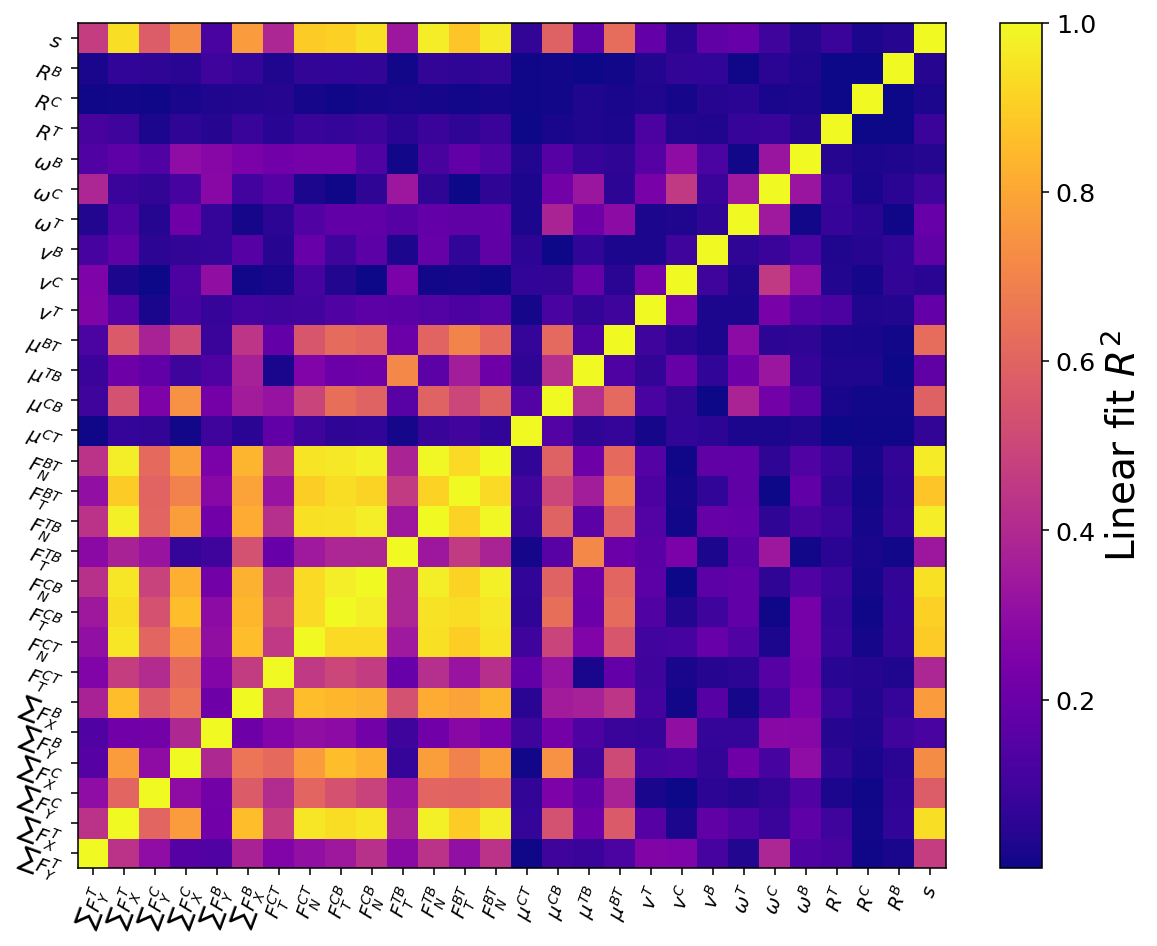

In [48]:
r2Matrix = np.zeros((len(params), len(params)))
slopeMatrix = np.zeros((len(params), len(params)))

# Calculate linear regression for every possible pair of parameters
for i in range(len(paramKeys)):
    for j in range(len(paramKeys)):            
        slope, intercept, r2, pValue, stdErr = linregress(params[paramKeys[i]], params[paramKeys[j]])
        r2Matrix[i,j] = np.abs(r2)
        slopeMatrix[i,j] = slope
        
fig, ax = plt.subplots(figsize=(10,8))

pc = ax.pcolor(r2Matrix)
cbar = fig.colorbar(pc)
cbar.set_label('Linear fit $R^2$', fontsize=20)

ax.set_xticks(np.arange(len(paramKeys)) + .5, [f'${p}$' for p in paramKeys], rotation=70, fontsize=10)
ax.set_yticks(np.arange(len(paramKeys)) + .5, [f'${p}$' for p in paramKeys], rotation=-20, fontsize=10)
plt.show()

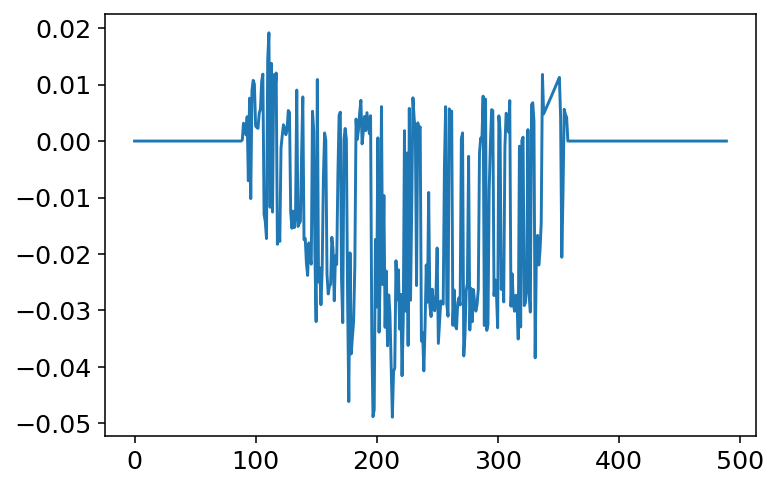

In [82]:
#allMu = list(params["\\mu^{CT}"]) + list(params["\\mu^{CB}"]) + list(params["\\mu^{TB}"]) + list(params["\\mu^{BT}"])
#allS = list(params["s"])*4

#plt.plot(allS, allMu, 'o')
plt.plot(params[0]["F^{BT}_T"])
plt.show()

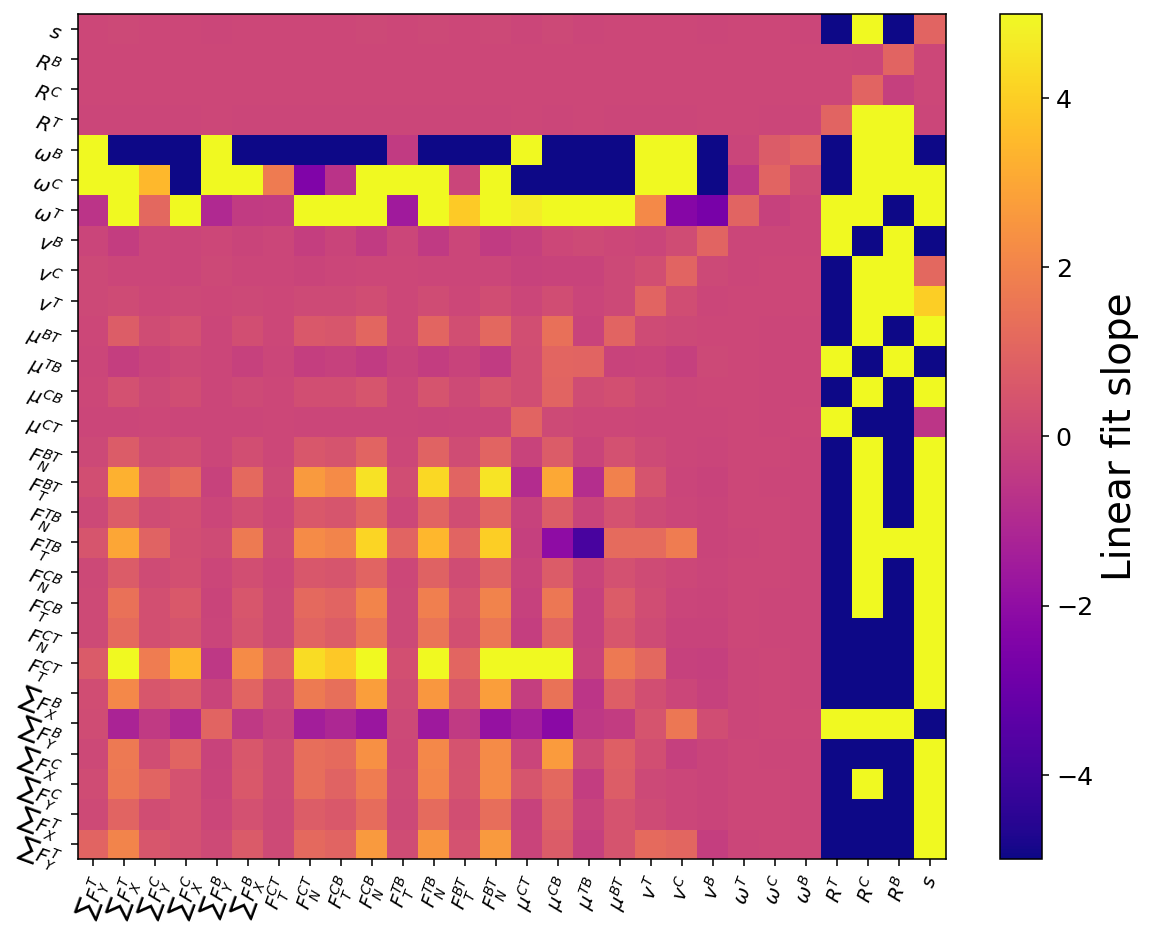

In [50]:
fig, ax = plt.subplots(figsize=(10,8))

pc = ax.pcolor(slopeMatrix, vmin=-5, vmax=5)
cbar = fig.colorbar(pc)
cbar.set_label('Linear fit slope', fontsize=20)

ax.set_xticks(np.arange(len(paramKeys)) + .5, [f'${p}$' for p in paramKeys], rotation=70, fontsize=10)
ax.set_yticks(np.arange(len(paramKeys)) + .5, [f'${p}$' for p in paramKeys], rotation=-20, fontsize=10)
plt.show()

## Multiple Trials

In [5]:
trials = [None]*len(fileList)
params = [None]*len(fileList)

for i in range(len(fileList)):
    trials[i] = Trial(syntheticFolder + fileList[i])
    trials[i].fixAllNan()

In [40]:
for i in range(len(trials)):
    params[i] = calcAllParams(trials[i])

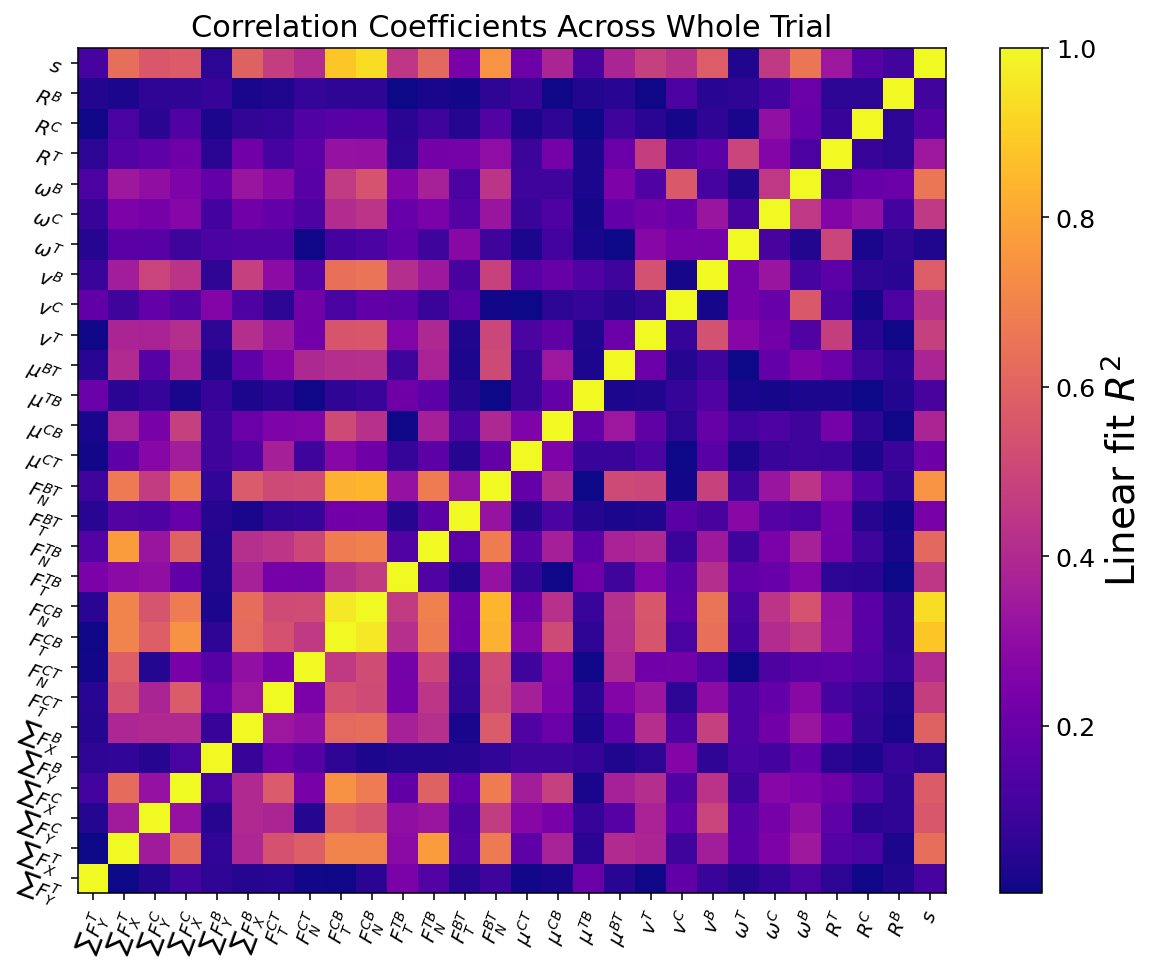

In [55]:
paramKeys = list(params[0].keys())

r2Matrix = np.zeros((len(paramKeys), len(paramKeys)))
slopeMatrix = np.zeros((len(paramKeys), len(paramKeys)))

# Calculate linear regression for every possible pair of parameters
for k in range(len(trials)):
    for i in range(len(paramKeys)):
        for j in range(len(paramKeys)):            
            slope, intercept, r2, pValue, stdErr = linregress(params[k][paramKeys[i]], params[k][paramKeys[j]])
            r2Matrix[i,j] += r2
            slopeMatrix[i,j] += slope
        
r2Matrix /= len(trials)        
slopeMatrix /= len(trials)

fig, ax = plt.subplots(figsize=(10,8))

pc = ax.pcolor(np.abs(r2Matrix))
cbar = fig.colorbar(pc)
cbar.set_label('Linear fit $R^2$', fontsize=20)

ax.set_xticks(np.arange(len(paramKeys)) + .5, [f'${p}$' for p in paramKeys], rotation=70, fontsize=10)
ax.set_yticks(np.arange(len(paramKeys)) + .5, [f'${p}$' for p in paramKeys], rotation=-20, fontsize=10)
ax.set_title('Correlation Coefficients Across Whole Trial')
plt.savefig('/eno/www/html/grainfail/jack/images/2022-05-03/whole_trial_corr.png')
plt.show()

## At failure point

In [62]:
def findFailurePoint(trial):
    # Smooth out the force curves on the central particle
    centerParticle = trial.particleNear([500, 500])
    
    smoothedForces = [savgol_filter(fArr, 11, 3) for fArr in trial.forceArr[centerParticle]]
    
    maxPoints = np.argmax(smoothedForces, axis=-1)
    
    drivingForce = np.argmin(np.abs(trial.averageForcePositions(centerParticle) - np.pi/2))
    
    return int(maxPoints[drivingForce])#int(np.mean(maxPoints))

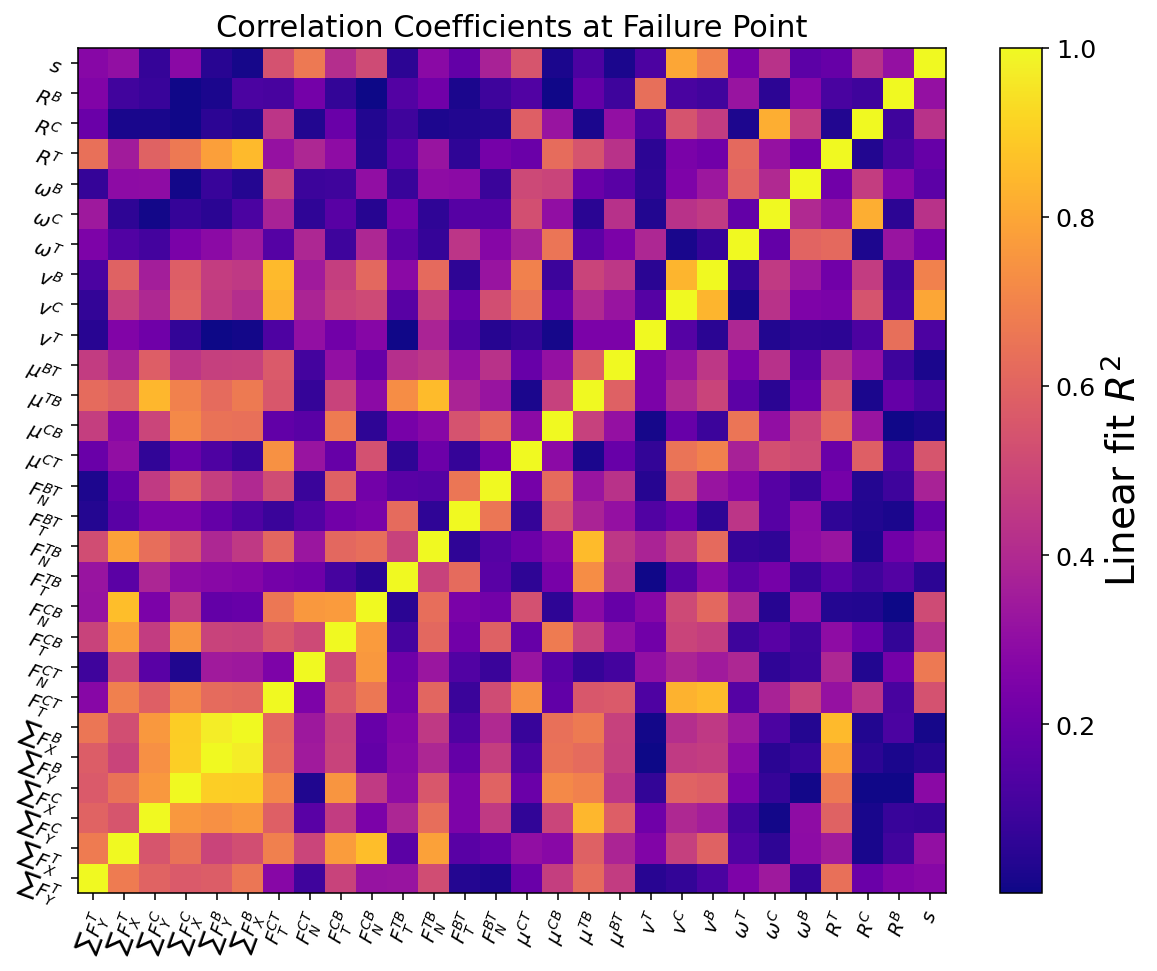

In [63]:
criticalValues = np.zeros((len(paramKeys), len(trials)))
paramIndices = dict(zip(paramKeys, np.arange(len(paramKeys))))

for i in range(len(trials)):
    failurePoint = findFailurePoint(trials[i])
    
    for j in range(len(paramKeys)):
        criticalValues[j,i] = params[i][paramKeys[j]][failurePoint]
    
# Now calculate correlations
r2Matrix = np.zeros((len(paramKeys), len(paramKeys)))
slopeMatrix = np.zeros((len(paramKeys), len(paramKeys)))

# Calculate linear regression for every possible pair of parameters
for i in range(len(paramKeys)):
    for j in range(len(paramKeys)):            
        slope, intercept, r2, pValue, stdErr = linregress(criticalValues[i], criticalValues[j])
        r2Matrix[i,j] += r2
        slopeMatrix[i,j] += slope

fig, ax = plt.subplots(figsize=(10,8))

pc = ax.pcolor(np.abs(r2Matrix))
cbar = fig.colorbar(pc)
cbar.set_label('Linear fit $R^2$', fontsize=20)

ax.set_xticks(np.arange(len(paramKeys)) + .5, [f'${p}$' for p in paramKeys], rotation=70, fontsize=10)
ax.set_yticks(np.arange(len(paramKeys)) + .5, [f'${p}$' for p in paramKeys], rotation=-20, fontsize=10)
ax.set_title('Correlation Coefficients at Failure Point')
#plt.savefig('/eno/www/html/grainfail/jack/images/2022-05-03/failure_point_corr.png')
plt.show()

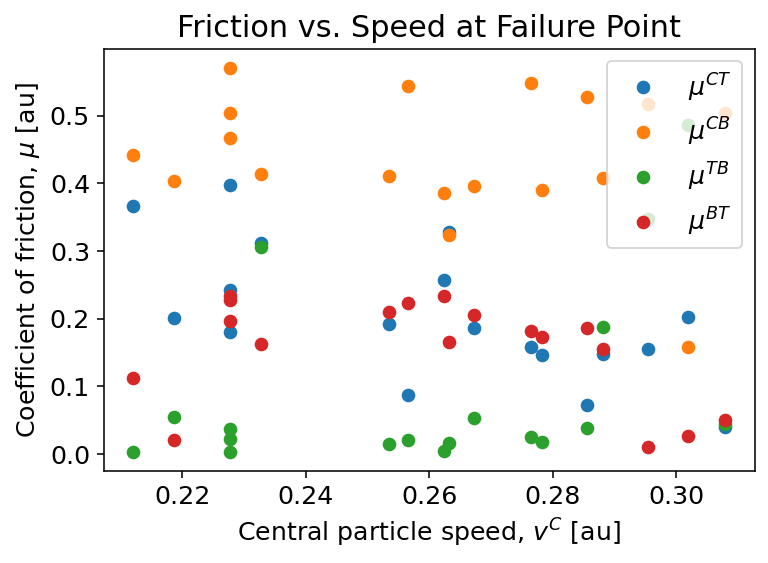

In [74]:
#plt.plot(params[0]["v^B"])
#plt.plot(params[0]["v^C"])
#plt.plot(trials[0].forceArr[3][0])
plt.plot(criticalValues[paramIndices["v^C"]], criticalValues[paramIndices["\\mu^{CT}"]], 'o', label="$\\mu^{CT}$")
plt.plot(criticalValues[paramIndices["v^C"]], criticalValues[paramIndices["\\mu^{CB}"]], 'o', label="$\\mu^{CB}$")
plt.plot(criticalValues[paramIndices["v^C"]], criticalValues[paramIndices["\\mu^{TB}"]], 'o', label="$\\mu^{TB}$")
plt.plot(criticalValues[paramIndices["v^C"]], criticalValues[paramIndices["\\mu^{BT}"]], 'o', label="$\\mu^{BT}$")

plt.ylabel(r'Coefficient of friction, $\mu$ [au]')
plt.xlabel('Central particle speed, $v^C$ [au]')
plt.title('Friction vs. Speed at Failure Point')
plt.legend()
plt.savefig('/eno/www/html/grainfail/jack/images/2022-05-03/friction_speed.png')
plt.show()